# Data Analysis with python II (tutorial)

In this tutorial, we will open a VTk data file, we can use the vtk library for this.

In [1]:
import vtk
import numpy as np
import matplotlib.pyplot as plt

We define the input directory and file name:

In [2]:
input_directory="./simulation_data/"
file_name = "turbulence_sub.vtk"

In [3]:
# Here we include some lines to select the file we want to read

reader = vtk.vtkDataSetReader()
reader.SetFileName(input_directory+file_name)

# Now, we read all the scalar and vector quantities
reader.ReadAllScalarsOn()
reader.ReadAllVectorsOn()
reader.Update()

In [4]:
# Now, let's have a first look into the data
data = reader.GetOutput()

# Let's see the data structure
#print(data)

As we can see the data consists of a 2D grid of 50x50 cells/pixels, i.e. 2500 grid cells/pixels in total.

The data are organised in 5 arrays:

    Array 0 name = rho
    Array 1 name = vx1
    Array 2 name = vx2
    Array 3 name = Bx1
    Array 4 name = Bx2
    
Which we can now read with:

In [5]:
dens = data.GetCellData().GetArray("rho")
velx = data.GetCellData().GetArray("vx1")
vely = data.GetCellData().GetArray("vx2")
bfix = data.GetCellData().GetArray("Bx1")
bfiy = data.GetCellData().GetArray("Bx2")

However, after reading the data, we notice that we have 1D arrays, instead of 2D. 


In [6]:
print(np.shape(dens))

(2500,)


Therefore, we need to re-shape the array into 2D.

We can use the information on the dimensions from teh original VTK file.

In [7]:
dim = data.GetDimensions()

vec = list(dim)
vec = [i-1 for i in dim]

print("unit_vectors =", vec)

unit_vectors = [50, 50, 0]


Let's then use the above information for re-shaping the array:

In [8]:
rho = np.reshape(dens,(vec[0],vec[1]))

print(np.shape(dens), np.shape(rho))

(2500,) (50, 50)


As we can see, the original density array has been converted from 1D to 2D.

Thus, let's do the same with all the other arrays.

In [9]:
vx = np.reshape(velx,(vec[0],vec[1]))
vy = np.reshape(vely,(vec[0],vec[1]))
Bx = np.reshape(bfix,(vec[0],vec[1]))
By = np.reshape(bfiy,(vec[0],vec[1]))

Now, let's take a first look at the 2D data

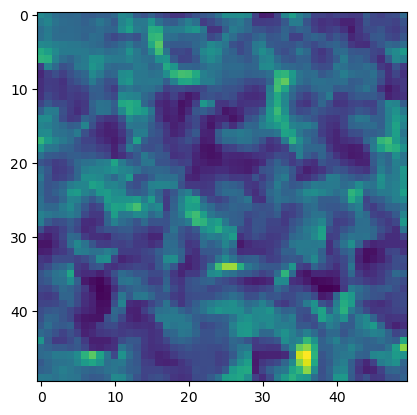

In [10]:
# Density map
plt.imshow(rho.T, interpolation='none')
plt.show()

This maps shows that the gas is highly turbulent. It has dense (in yellow) and difusse (in drak purple) regions.


Let's now calculate and plot the flow speeds:

$$ v = \sqrt{v_x^2 + v_y^2}$$

And teh magnetic flux densities:

$$ B = \sqrt{B_x^2 + B_y^2}$$

In [11]:
# Flow speed
speed = np.sqrt(vx**2+vy**2)

# Magnetic field
bmagf = np.sqrt(Bx**2+By**2)

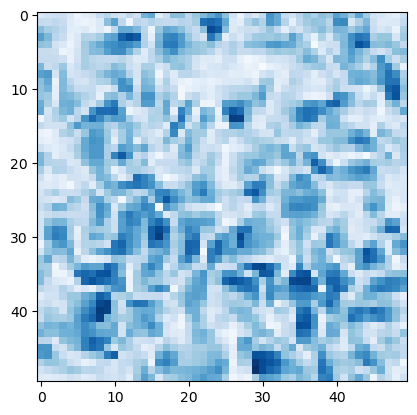

In [12]:
# Flow speed map
plt.imshow(speed.T, interpolation='none', cmap='Blues')
plt.show()

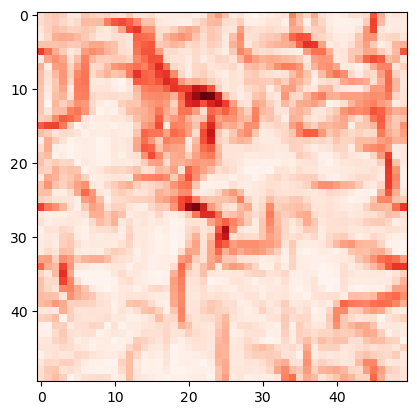

In [15]:
# Magnetic flux density map
plt.imshow(bmagf.T, interpolation='none', cmap='Reds')
plt.show()